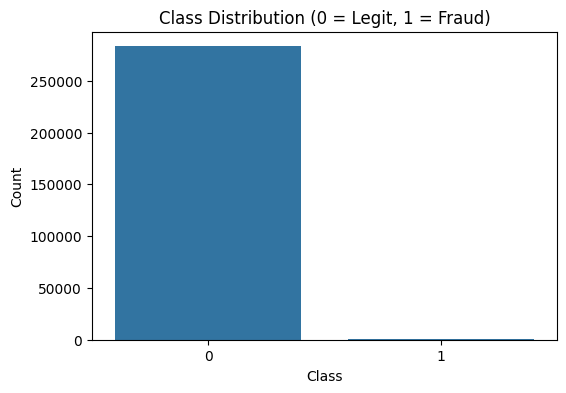

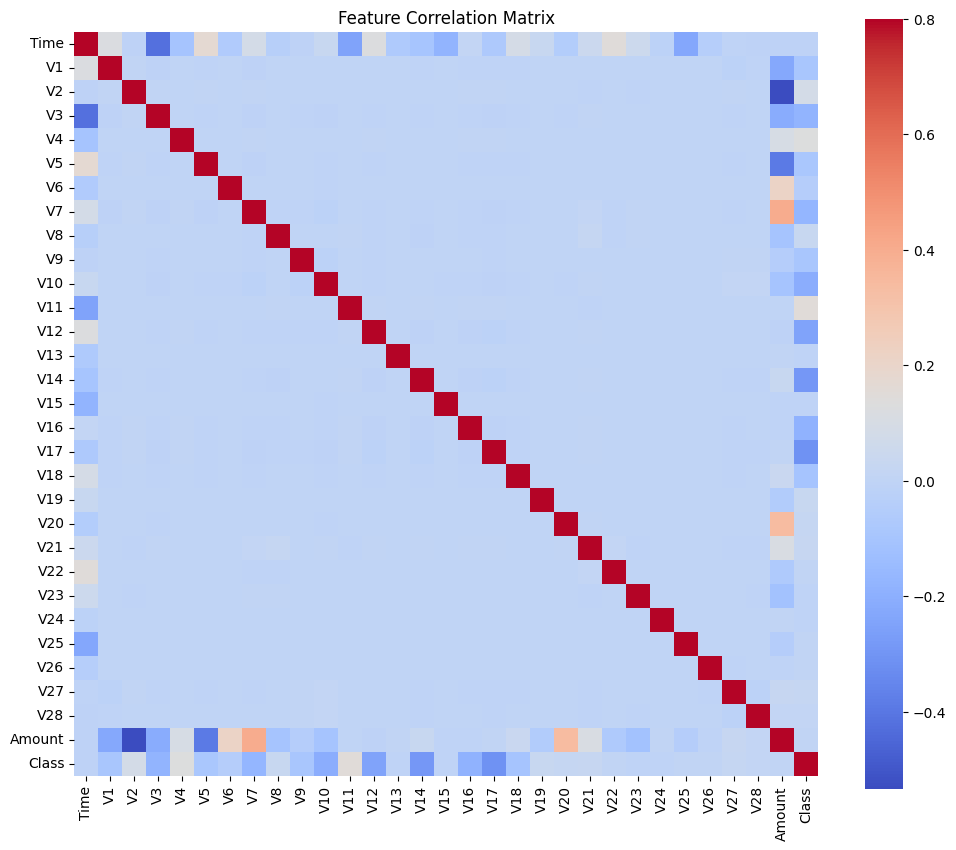

Accuracy: 0.9994713283755683
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56651
         1.0       0.97      0.71      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746



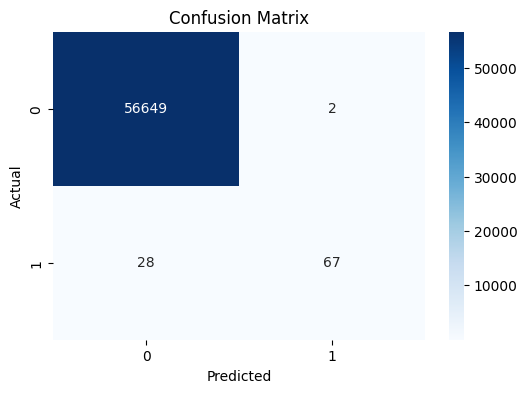

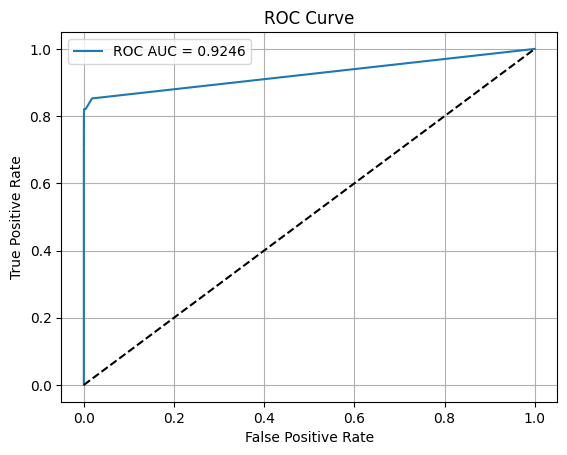

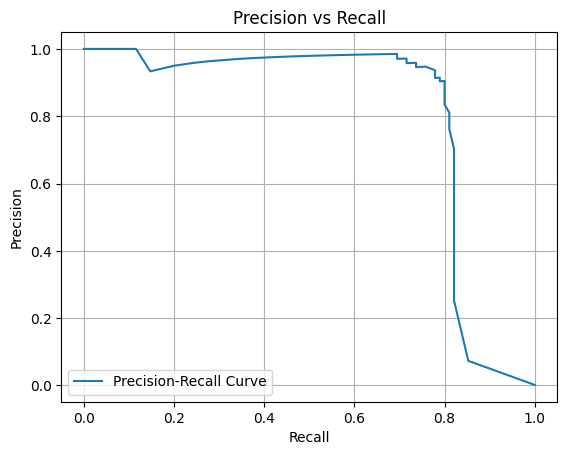

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


C:\Users\Samy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
import gradio as gr

# Step 2: Load Dataset
df = pd.read_csv("C:/Users/Samy/Downloads/creditcard.csv")  # Replace with your dataset path
df.drop_duplicates(inplace=True)

# Step 3: Basic Visualizations
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Class')
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Correlation matrix (only numerical)
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', vmax=0.8, square=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Step 4: Preprocessing
imputer = SimpleImputer(strategy='median')
df[df.columns] = imputer.fit_transform(df)

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Step 6: Evaluation
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

# Step 7: Gradio Interface
def predict_transaction(*features):
    input_data = np.array(features).reshape(1, -1)
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)[0]
    proba = model.predict_proba(input_scaled)[0][1]
    return "Fraud" if prediction == 1 else "Legit", f"Fraud Probability: {proba:.2%}"

# Create inputs dynamically based on feature range
feature_labels = list(X.columns)
gr_inputs = [
    gr.Slider(minimum=float(df[col].min()), maximum=float(df[col].max()), step=0.1, label=col)
    for col in feature_labels
]

interface = gr.Interface(
    fn=predict_transaction,
    inputs=gr_inputs,
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Fraud Probability")
    ],
    title="Credit Card Fraud Detection",
    description="Input transaction details to detect fraud. Uses a trained Random Forest model."
)

interface.launch()